In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import json
import yaml
from pathlib import Path

%matplotlib inline
sns.set()

2023-05-12 19:48:06.985597: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
from mlrl.procgen import META_ALLOWED_COMBOS
META_ALLOWED_COMBOS['bigfish'] = META_ALLOWED_COMBOS['bigfish'][:4]

In [4]:
from mlrl.experiments.eval_procgen_meta_policies import load_best_meta_policy, get_wandb_info_from_run_dir


run_path = Path('outputs/runs/ppo_run_48-08-23-02-05-2023/')
run_info = get_wandb_info_from_run_dir(run_path)
exclude_keys = ['learning_rate', 'name']
run_info['run_args'] = {
    k: v for k, v in run_info['config'].items()
    if k not in exclude_keys
}
# load_best_policy(run_info)
# plt.show()

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


pygame 2.1.3 (SDL 2.0.22, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
Using TensorFlow 2.12.0


In [5]:
from tensorflow.keras.utils import Progbar
from mlrl.experiments.procgen_meta import create_batched_procgen_meta_envs, load_pretrained_q_network
from mlrl.experiments.procgen_meta import reset_object_level_metrics, get_object_level_metrics
from mlrl.procgen.time_limit_observer import TimeLimitObserver
from mlrl.runners.eval_runner import EvalRunner

args = run_info['run_args']
# n_object_level_episodes = 10
# policy = run_info['best_policy']

percentile = run_info['config']['pretrained_percentile']

args.update({
    'pretrained_percentile': percentile,
    'expand_all_actions': True,
    'finish_on_terminate': True,
})

object_config = load_pretrained_q_network(
    folder=args['pretrained_runs_folder'],
    run=args['pretrained_run'],
    percentile=args.get('pretrained_percentile', 0.75),
    verbose=False
)

2023-05-12 19:48:16.920396: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-12 19:48:16.920468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: c533667038f4
2023-05-12 19:48:16.920478: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: c533667038f4
2023-05-12 19:48:16.920680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-05-12 19:48:16.920714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 510.60.2


In [6]:
class TransitionObserver:

    def __init__(self, meta_env):
        self.last_tree = None
        self.meta_env = meta_env
        self.frames = [[]]
        self.infos = []
        self.episode_counter = 0

    def __call__(self, obs, reward, object_level_done, info):
        
        if self.meta_env.done:
            # self.frames[self.episode_counter].append(self.meta_env.object_env.render(mode='rgb_array'))
            # self.last_tree = self.meta_env.tree.copy()
            object_env = self.meta_env.object_env.env
            object_state = object_env.callmethod('get_state')
            self.frames[self.episode_counter].append(self.meta_env.render(mode='rgb_array'))
            object_env.callmethod('set_state', object_state)

        if object_level_done:
            self.episode_counter += 1
            self.frames.append([])
            info['reward'] = reward
            self.infos.append(info)


batched_meta_env = create_batched_procgen_meta_envs(
    n_envs=1,
    object_config=object_config,
    **args
)

meta_env = batched_meta_env.envs[0]

observer = TransitionObserver(meta_env)

n_object_level_episodes = 3
max_object_level_steps = 50

time_limit = TimeLimitObserver(meta_env, max_object_level_steps)
meta_env.object_level_transition_observers.extend([time_limit, observer])


def failed_before_time_out() -> bool:
    failed_too_early = any(
        stats['steps'] < max_object_level_steps
        for stats in meta_env.object_level_metrics.episode_stats
    )

    # {
    #     'ObjectLevelMeanReward': sum_of_returns / max(1, n_episodes),
    #     'ObjectLevelMeanStepsPerEpisode': total_steps / max(1, n_episodes),
    #     'ObjectLevelEpisodes': n_episodes,
    #     'ObjectLevelCurrentEpisodeReturn': self.return_val,
    #     'ObjectLevelCurrentEpisodeSteps': self.n_steps
    # }

    metrics = meta_env.object_level_metrics.get_results()
    n_episodes = metrics['ObjectLevelEpisodes']
    curr_steps = metrics['ObjectLevelCurrentEpisodeSteps']
    reward = metrics['ObjectLevelCurrentEpisodeReturn']
    print(f'Episode: {n_episodes:3d} | Step: {curr_steps:3d} | Reward: {reward}',
          end='\n' if failed_too_early else '\r')

    return failed_too_early


prog_bar = Progbar(
    n_object_level_episodes,
    unit_name='episode',
    stateful_metrics=['ObjectLevelMeanReward',
                      'ObjectLevelMeanStepsPerEpisode',
                      'ObjectLevelEpisodes', 
                      'ObjectLevelCurrentEpisodeReturn',
                      'ObjectLevelCurrentEpisodeSteps']
)


def completed_n_episodes() -> bool:
    n_complete = sum([
        env.object_level_metrics.get_num_episodes()
        for env in batched_meta_env.envs
    ])

    metrics = get_object_level_metrics(batched_meta_env)
    prog_bar.update(n_complete, values=metrics.items())

    return n_complete >= n_object_level_episodes

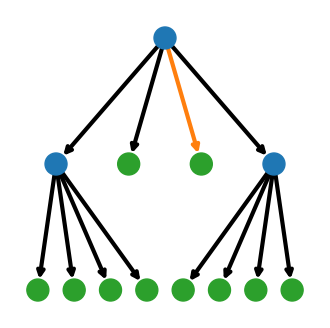

In [9]:
from mlrl.utils.plot_search_tree import plot_tree

meta_env.reset()
meta_env.step(1)
meta_env.step(2)
meta_env.step(5)

node_size = 250
edge_width = 3
figsize = (4, 4)
plot_tree(meta_env.search_tree_policy.tree, meta_env.search_tree_policy, figsize=figsize, zoom=1, node_label_threshold=0, show=False,
          edge_width=edge_width, small_node_size=node_size, arrowstyle='->', title=None)
plt.savefig('figures/tree1.pdf', bbox_inches='tight')
plt.show();

In [12]:
meta_env.search_tree_policy

Greedy Policy Trajectory: LEFT+UP

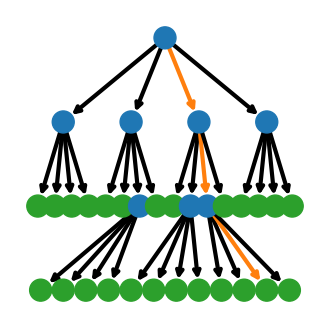

In [23]:
from mlrl.utils.plot_search_tree import plot_tree

meta_env.reset()
# meta_env.step(1);
# meta_env.step(3);
# meta_env.step(5);
# meta_env.step(8);
meta_env.step(1)
meta_env.step(2)
meta_env.step(3)
meta_env.step(4)
meta_env.step(5)
meta_env.step(16)
meta_env.step(15)
meta_env.step(12)

plot_tree(meta_env.search_tree_policy.tree, meta_env.search_tree_policy, figsize=figsize, zoom=1, node_label_threshold=0, show=False,
          edge_width=edge_width, small_node_size=node_size, arrowstyle='->', title=None)
plt.savefig('figures/tree2.pdf', bbox_inches='tight')
plt.show();

In [33]:
from mlrl.utils.plot_search_tree import plot_tree


def show_interesting_traj(*args, **kwargs):
    traj = meta_env.search_tree_policy.get_trajectory()
    if len(traj) < 5:
        return False

    def show():
        plt.imshow(meta_env.tree_policy_renderer(meta_env.object_env,
                                                 meta_env.search_tree_policy))
        plt.axis('off')
        plt.show();
        plot_tree(meta_env.tree, figsize=(7, 7))
        plt.show();

    print('Showing interesting trajectory')
    show()
    policy_step = policy.action(batched_meta_env.current_time_step())
    batched_meta_env.step(policy_step.action);
    show()

    return not meta_env.done and traj != meta_env.search_tree_policy.get_trajectory()

In [34]:
eval_runner = EvalRunner(
    eval_env=batched_meta_env,
    policy=policy,
    rewrite_rewards=True,
    use_tf_function=False,
    convert_to_eager=False,
    # eval_steps=500,
    stop_eval_condition=show_interesting_traj
    # stop_eval_condition=failed_before_time_out
    # stop_eval_condition=completed_n_episodes
)

Showing interesting trajectory


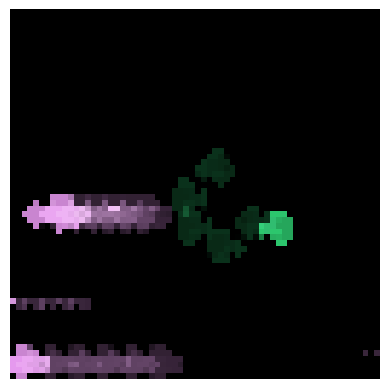

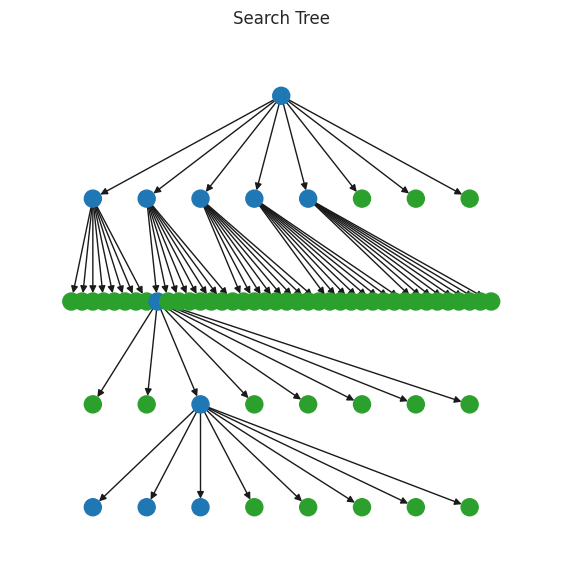

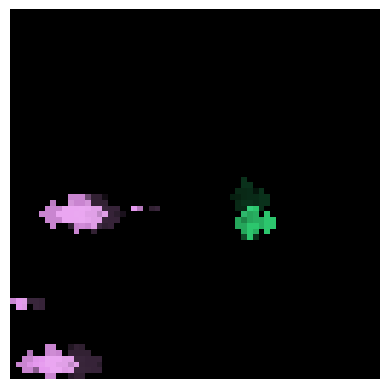

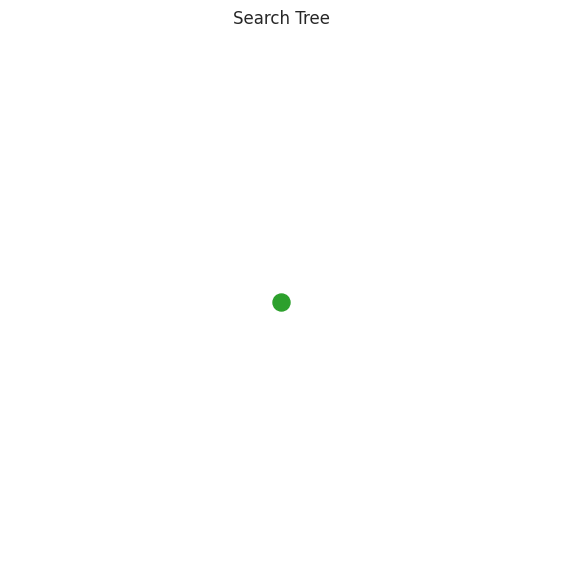

Showing interesting trajectory


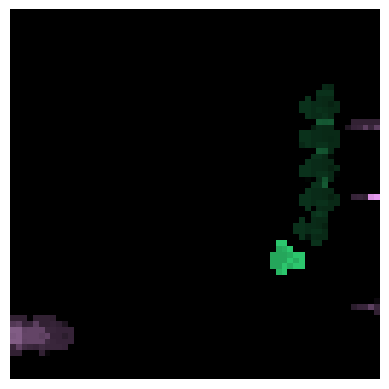

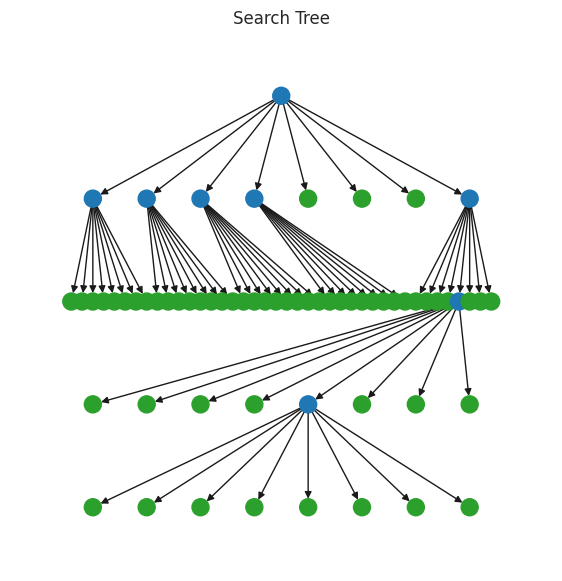

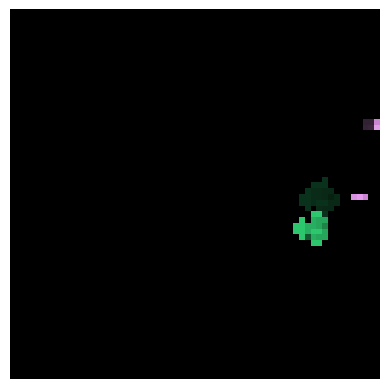

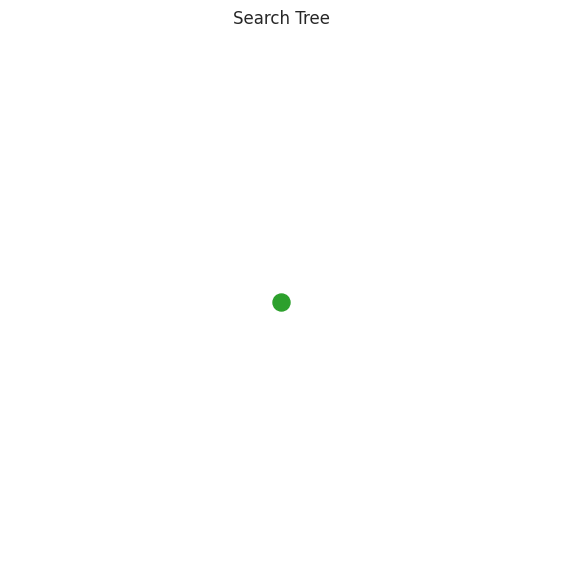

Showing interesting trajectory


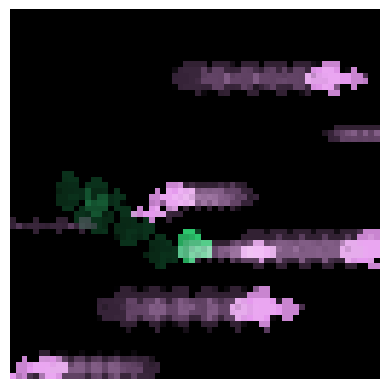

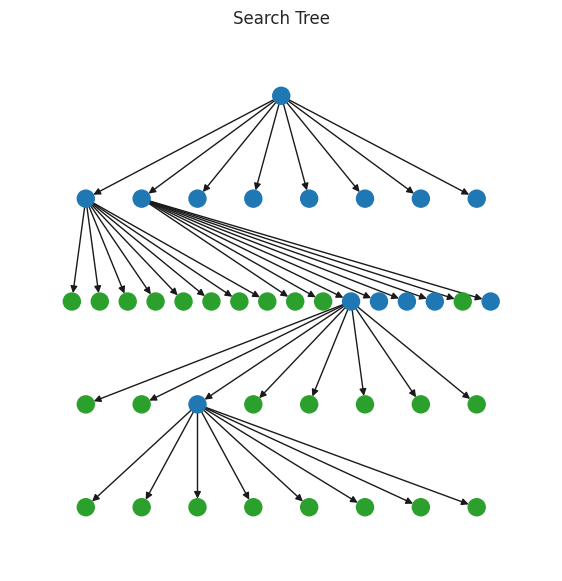

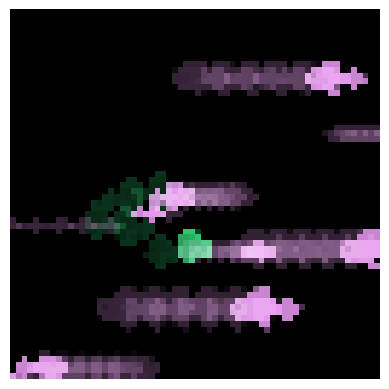

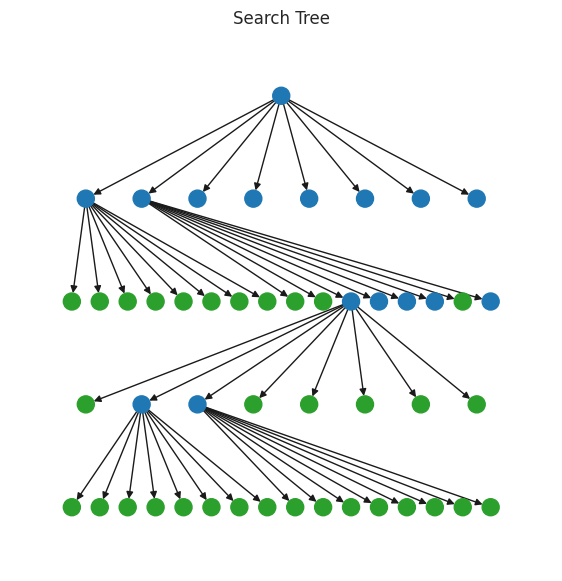

Evaluation stats:
EvalTime: 132.369


In [35]:
reset_object_level_metrics(batched_meta_env)
eval_results = eval_runner.run()
object_level_results = get_object_level_metrics(batched_meta_env)

evaluations = {
    **args,
    **object_config,
    **eval_results,
    **object_level_results
}


In [ ]:
from mlrl.utils.render_utils import save_video, embed_mp4

embed_mp4(save_video(observer.frames[0], fps=1))

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import json
import yaml
from pathlib import Path

%matplotlib inline
sns.set()

2023-05-14 13:55:21.621164: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# episode_stats_df = pd.concat([
#     pd.read_csv(os.path.join(baselines_eval_folder, 'episode_stats.csv')),
#     *[pd.read_csv(os.path.join(folder, 'episode_stats.csv')) for folder in learned_eval_folders]
# ]).reset_index()


episode_stats_df = pd.concat([
    pd.read_csv('outputs/baseline/procgen/final/episode_stats.csv'),
    *[pd.read_csv(p) for p in Path('outputs/eval/procgen/final').glob('episode_stats*')]
]).reset_index()

# for consistent hue order
policy_hue_order = episode_stats_df['Meta-level Policy'].unique()

In [3]:
episode_stats_df.head()

,index,Run ID,Meta-level Policy,Pretrained Percentile,Number of Steps,Return
0,0,NaN,AStar,0.25,29,0.0
1,1,NaN,AStar,0.25,322,54.0
2,2,NaN,AStar,0.25,500,117.0
3,3,NaN,AStar,0.25,500,107.0
4,4,NaN,AStar,0.25,500,111.0


In [4]:
episodes_df = episode_stats_df.copy()
episodes_df = episodes_df[episodes_df['Meta-level Policy'] != 'Random']
episodes_df['Meta-level Policy'] = episodes_df['Meta-level Policy'].apply(lambda x: 'Random' if 'Random' in x else x)
means_df = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile']).mean().reset_index()
means_df

,Meta-level Policy,Pretrained Percentile,index,Number of Steps,Return
0,AStar,0.10,595.500000,470.916667,96.916667
1,AStar,0.25,8.000000,461.823529,97.235294
2,AStar,0.50,503.500000,488.125000,102.666667
3,AStar,0.75,527.500000,485.958333,113.250000
4,AStar,0.90,428.500000,500.000000,116.541667
5,Instant Terminate,0.10,573.500000,64.850000,6.400000
6,Instant Terminate,0.25,66.500000,136.040000,16.240000
7,Instant Terminate,0.50,166.500000,184.230000,20.450000
8,Instant Terminate,0.75,266.500000,227.230000,28.790000
9,Instant Terminate,0.90,366.500000,230.400000,35.980000


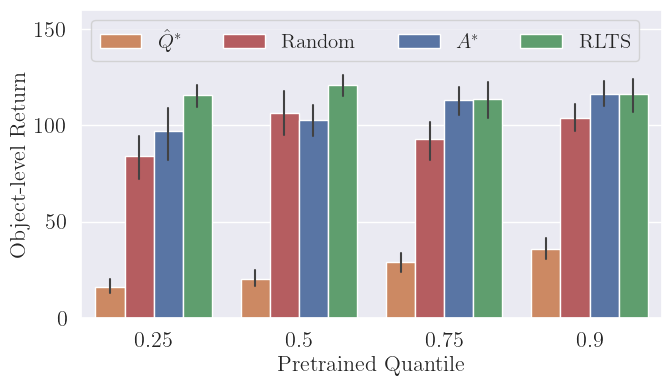

In [6]:
# sns.set(font_scale=1)
# sns.set()
# sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
plt.rcParams.update({
    'font.family':'serif',
    "text.usetex": True,
    # 'font.size': 20,
    # 'axes.labelsize': 18, 'axes.titlesize': 20, 
    'savefig.facecolor': 'white',
})

# Set the default text font size
plt.rc('font', size=16)
# Set the axes title font size
plt.rc('axes', titlesize=16)
# Set the axes labels font size
plt.rc('axes', labelsize=16)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=16)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=16)
# Set the legend font size
plt.rc('legend', fontsize=18)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)



plt.figure(figsize=(15/2, 8/2))

episode_stats_df = pd.concat([
    pd.read_csv('outputs/baseline/procgen/final/episode_stats.csv'),
    *[pd.read_csv(p) for p in Path('outputs/eval/procgen/final').glob('episode_stats*')]
]).reset_index()

episodes_df = episode_stats_df.copy()
episodes_df = episodes_df[episodes_df['Meta-level Policy'] != 'Random']
episodes_df = episodes_df[episodes_df['Pretrained Percentile'] != 0.1]

policy_labels = {
    'Instant Terminate': '$\hat{Q}^*$',
    'Random (No Terminate)': 'Random',
    'AStar': '$A^*$',
    'Learned Meta-Policy': 'RLTS'
}
episodes_df['Meta-level Policy'] = episodes_df['Meta-level Policy'].apply(policy_labels.get)

means_df = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile']).mean().reset_index()
policy_rank = ['Instant Terminate', 'Random', 'AStar', 'Learned Meta-Policy']
pallete = sns.color_palette()
policy_pallete = [pallete[1], pallete[3], pallete[0], pallete[2]]

ax = sns.barplot(data=episodes_df, x='Pretrained Percentile', y='Return', hue='Meta-level Policy',
                 hue_order=policy_labels.values(), palette=policy_pallete, errwidth=1.5)

plt.ylabel('Object-level Return')
plt.xlabel('Pretrained Quantile')
# plt.title(f'Object-level Return vs Pretrained Percentile')

# ax.legend(bbox_to_anchor=(.5, -.15),
#           ncol=2, fancybox=False, shadow=False)

ax.legend(ncols=4, loc='upper left', fontsize=15)
ax.set_ylim([0, 160])

# data at figures/data/bigfish/meta-policies-object-level-return.csv
plt.savefig("figures/meta-policies-object-level-return.pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_4562/600121077.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return Interval'] = df['Rounded Return'].apply(lambda x: f'[{x}, {x + n})')
/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


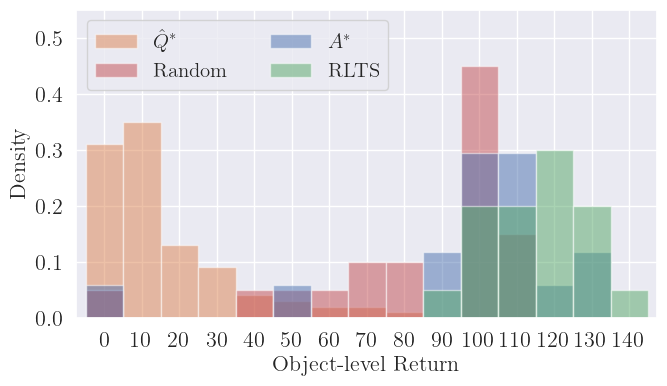

In [7]:
percentile = 0.25

# sns.set(font_scale=2.5)
# sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
plt.rcParams.update({
    'font.family':'serif',
    "text.usetex": True,
    # 'font.size': 20
})

# plt.figure(figsize=(15/2, 8/2))

episodes_df = episode_stats_df.copy()
episodes_df = episodes_df[episodes_df['Meta-level Policy'] != 'Random']
episodes_df = episodes_df[episodes_df['Pretrained Percentile'] != 0.1]

policy_labels = {
    'Instant Terminate': '$\hat{Q}^*$',
    'Random (No Terminate)': 'Random',
    'AStar': '$A^*$',
    'Learned Meta-Policy': 'RLTS'
}
episodes_df['Meta-level Policy'] = episodes_df['Meta-level Policy'].apply(policy_labels.get)

episodes_df.sort_values(by='Meta-level Policy', inplace=True)

n = 10
def round_return(x):
    return round(x / n) * n

episodes_df['Rounded Return'] = episodes_df['Return'].apply(round_return)
counts_df = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile', 'Rounded Return']).count().reset_index()
counts_df.rename(columns={'Return': 'Count'}, inplace=True)
counts_df.drop(columns=['index', 'Number of Steps'], inplace=True)

total_episodes = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile']).count().reset_index()
total_episodes.rename(columns={'index': 'Count'}, inplace=True)
total_episodes = total_episodes[['Meta-level Policy', 'Pretrained Percentile', 'Count']]


def normalize_counts(row):
    index, data = row
    right_policy = total_episodes['Meta-level Policy'] == data['Meta-level Policy']
    right_percentile = total_episodes['Pretrained Percentile'] == data['Pretrained Percentile']
    n = total_episodes[right_policy & right_percentile]['Count'].values[0]
    data['Density'] = data['Count'] / n
    return data

counts_df = pd.DataFrame(map(normalize_counts, counts_df.iterrows()))


fig, ax = plt.subplots(figsize=(15/2, 8/2))
# for policy in episodes_df['Meta-level Policy'].unique():
#     right_policy = episodes_df['Meta-level Policy'] == policy
#     sns.kdeplot(episodes_df[right_percentile & right_policy]['Return'], label=policy, ax=ax)
df = counts_df[counts_df['Pretrained Percentile'] == percentile]
df['Return Interval'] = df['Rounded Return'].apply(lambda x: f'[{x}, {x + n})')
df.sort_values(by=['Rounded Return', 'Meta-level Policy'], inplace=True)
# df.set_index('Rounded Return', inplace=True)
# df = df[['Meta-level Policy', 'Density']]
# sns.barplot(data=df, x='Return Interval', y='Density', hue='Meta-level Policy', ax=ax, hue_order=policy_hue_order)
df = df.pivot(index='Rounded Return', columns='Meta-level Policy', values='Density').fillna(0)
pallete = sns.color_palette()
policy_pallete = [pallete[1], pallete[3], pallete[0], pallete[2]]
df = df[policy_labels.values()]

for policy, colour in zip(df.columns, policy_pallete):
    df[policy].plot.bar(ax=ax, color=colour, alpha=0.5, width=1, rot=0)
# ax.set_title(f'Pretrained Percentile: {percentile}')
# ax.set_xlim([0, 80])

ax.set_xlabel('Object-level Return')
ax.set_ylabel('Density')
# ax.legend(loc='upper left', fontsize=15)
# ax.legend(fontsize=15, bbox_to_anchor=(.6, .5))
ax.legend(fontsize=15, ncol=2)
ax.set_ylim([0, 0.55])

# data at figures/data/bigfish/meta-policies-return-distributions.csv
plt.savefig('figures/return-distributions-025.pdf', bbox_inches='tight')

plt.show()

In [43]:
df[df.index == 100.0]

Meta-level Policy,$\hat{Q}^*$,Random,$A^*$,MLRL
Rounded Return,,,,
100,0.0,0.45,0.294118,0.2


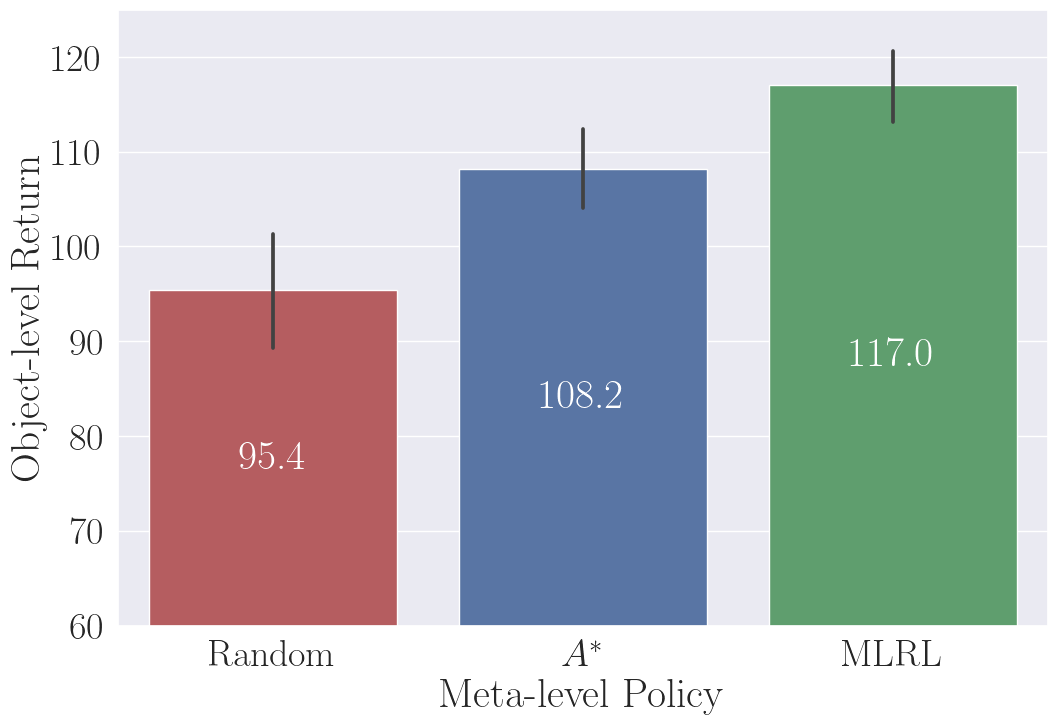

In [13]:
sns.set(font_scale=2.5)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

plt.figure(figsize=(12, 8))

episode_stats_df = pd.concat([
    pd.read_csv('outputs/baseline/procgen/final/episode_stats.csv'),
    *[pd.read_csv(p) for p in Path('outputs/eval/procgen/final').glob('episode_stats*')]
]).reset_index()

episodes_df = episode_stats_df.copy()
episodes_df = episodes_df[~episodes_df['Meta-level Policy'].isin(['Random', 'Instant Terminate'])]
episodes_df = episodes_df[episodes_df['Pretrained Percentile'] != 0.1]

policy_labels = {
    'Instant Terminate': '$\hat{Q}^*$',
    'Random (No Terminate)': 'Random',
    'AStar': '$A^*$',
    'Learned Meta-Policy': 'RLTS'
}
episodes_df['Meta-level Policy'] = episodes_df['Meta-level Policy'].apply(policy_labels.get)

means_df = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile']).mean().reset_index()

pallete = sns.color_palette()
policy_pallete = [pallete[3], pallete[0], pallete[2]]

# episodes_df = episodes_df[episodes_df['Pretrained Percentile'] != 0.1]

policy_order = {policy: i for i, policy in enumerate(policy_labels.values())}

episodes_df.sort_values(by='Meta-level Policy', inplace=True, 
                        key=lambda x: x.map(policy_order))


ax = sns.barplot(data=episodes_df, x='Meta-level Policy', y='Return', palette=policy_pallete)
ax.bar_label(ax.containers[0], fmt='%.1f', label_type='center', color='white')

# ax.bar_label(ax.containers[0], labels=action_labels,
#             label_type='center', rotation=90, color='white')

plt.ylabel('Object-level Return')
# ax.set_xticklabels(['Random', 'AStar', 'Learned\nMeta-Policy'])
ax.set_ylim([60, 125])

plt.show()

In [45]:
episodes_df[(episodes_df['Meta-level Policy'] == 'Learned Meta-Policy') & (episodes_df['Pretrained Percentile'] == 0.75)].head()

,index,Run ID,Meta-level Policy,Pretrained Percentile,Number of Steps,Return
727,0,guher2s1/devoted-frost-278,Learned Meta-Policy,0.75,500,126.0
728,1,guher2s1/devoted-frost-278,Learned Meta-Policy,0.75,500,113.0
729,2,guher2s1/devoted-frost-278,Learned Meta-Policy,0.75,500,137.0
730,3,guher2s1/devoted-frost-278,Learned Meta-Policy,0.75,500,121.0
731,4,guher2s1/devoted-frost-278,Learned Meta-Policy,0.75,500,111.0


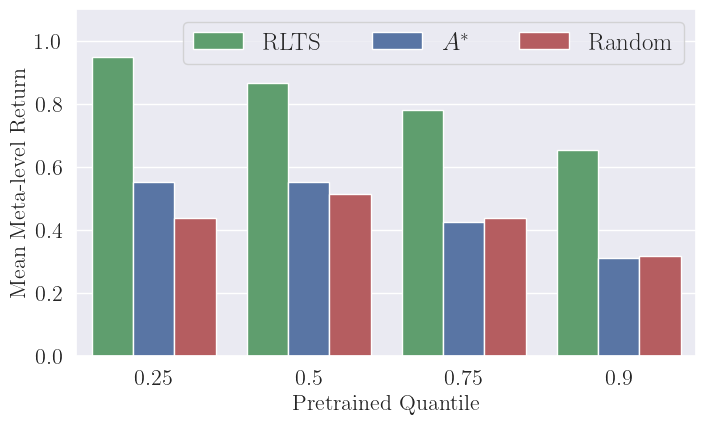

In [8]:
baselines_eval_folder = 'outputs/baseline/procgen/52-55-04-01-05-2023-complete'
learned_eval_folders = [
    'outputs/eval/procgen/41-09-18-02-05-2023',
    'outputs/eval/procgen/31-29-12-03-05-2023',
    # 'outputs/eval/procgen/54-17-22-09-05-2023' # 0.1
]

results_df = pd.concat([
    pd.read_csv(os.path.join(baselines_eval_folder, 'results.csv')),
    # pd.read_csv(os.path.join(baselines_eval_folder, 'results01.csv')),
    # pd.read_csv(os.path.join(baselines_eval_folder, 'results01-2.csv')),
    pd.read_csv(os.path.join(learned_eval_folders[0], 'results2.csv')),
    *[pd.read_csv(os.path.join(folder, 'results.csv')) for folder in learned_eval_folders]
]).reset_index()


plt.rcParams.update({
    'font.family':'serif',
    "text.usetex": True,
    # 'font.size': 20,
    # 'axes.labelsize': 18, 'axes.titlesize': 20, 
    'savefig.facecolor': 'white',
})

# Set the default text font size
plt.rc('font', size=16)
# Set the axes title font size
plt.rc('axes', titlesize=16)
# Set the axes labels font size
plt.rc('axes', labelsize=16)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=16)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=16)
# Set the legend font size
plt.rc('legend', fontsize=18)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)


plot_name, plot_key = 'Mean Meta-level Return', 'EvalRewrittenAverageReturn'

plt.figure(figsize=(16 / 2, 9 / 2))

means_df = results_df.groupby(['Meta-level Policy', 'pretrained_percentile']).mean().reset_index()
means_df = means_df[~means_df['Meta-level Policy'].isin(['Random', 'Instant Terminate'])]


policy_labels = {
    'Instant Terminate': '$\hat{Q}^*$',
    'Random (No Terminate)': 'Random',
    'AStar': '$A^*$',
    'Learned Meta-Policy': 'RLTS'
}
means_df['Meta-level Policy'] = means_df['Meta-level Policy'].apply(policy_labels.get)

means_df.sort_values(by='Meta-level Policy', inplace=True)

# sns.lineplot(data=means_df, x='pretrained_percentile', y=plot_key, hue='Meta-level Policy', alpha=0.25)
# ax = sns.scatterplot(data=means_df, x='pretrained_percentile', y=plot_key, hue='Meta-level Policy', legend=False)

pallete = sns.color_palette()
policy_pallete = [pallete[3], pallete[0], pallete[2]][::-1]


policy_order = {policy: i for i, policy in enumerate(policy_labels.values())}

means_df.sort_values(by='Meta-level Policy', inplace=True, 
                        key=lambda x: -x.map(policy_order))

ax = sns.barplot(data=means_df, x='pretrained_percentile', y=plot_key, hue='Meta-level Policy', palette=policy_pallete)

# ax.legend(loc='upper center', bbox_to_anchor=(.5, -.15),
#           ncol=3, fancybox=False, shadow=False)
ax.legend(ncols=3)
ax.set_ylim([0, 1.1])

plt.xlabel('Pretrained Quantile')
plt.ylabel(plot_name)
# plt.title(f'{plot_name} vs Pretrained Percentile')

# means_df.to_csv('figures/data/bigfish/meta-policies-mean-meta-level-return.csv')
plt.savefig("figures/meta-policies-mean-meta-level-return.pdf", bbox_inches="tight")


In [3]:
from mlrl.experiments.eval_procgen_meta_policies import load_best_meta_policy
from mlrl.utils.wandb_utils import get_wandb_info_from_run_dir
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf

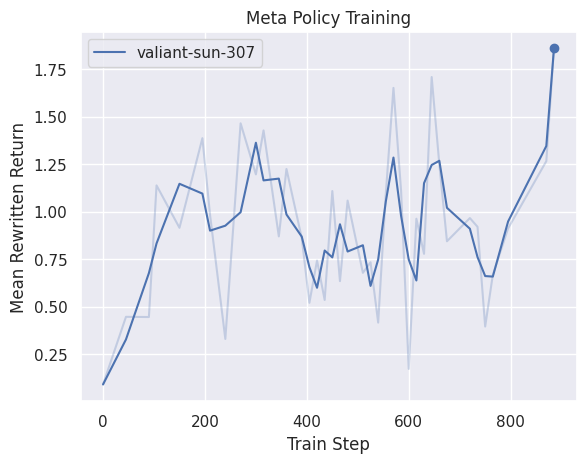

In [4]:
meta_run = 'outputs/runs/ppo_run_52-06-02-13-05-2023/'

run_info = get_wandb_info_from_run_dir(meta_run)

load_best_meta_policy(run_info)
plt.show()

In [5]:
from mlrl.procgen.procgen_state import ProcgenProcessing

In [6]:
from mlrl.experiments.procgen_meta import make_gym_procgen
object_config = run_info['config']['object_level_config']
object_env = make_gym_procgen(object_config)

In [7]:
obs = object_env.reset()
_, q_vals = ProcgenProcessing.call(np.expand_dims(obs, 0))
q_vals.argmax()

7

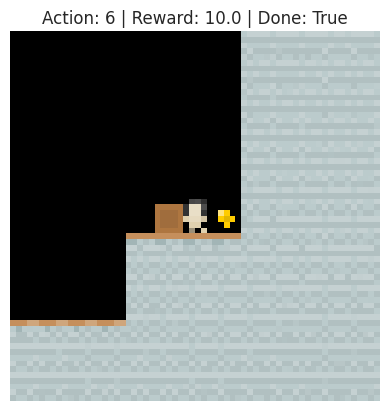

In [12]:
import IPython.display as display

obs = object_env.reset()
done = False
try:
    while not done:
        _, q_vals = ProcgenProcessing.call(np.expand_dims(obs, 0))
        action = q_vals.argmax()
        obs, reward, done, info = object_env.step(action)
        plt.imshow(obs)
        plt.axis('off')
        plt.title(f'Action: {action} | Reward: {reward} | Done: {done}')
        plt.show()
        display.clear_output(wait=True)
except KeyboardInterrupt:
    pass

In [14]:
from mlrl.procgen.procgen_env import make_vectorised_procgen
vec_object_env = make_vectorised_procgen(object_config, n_envs=1)

In [15]:
agent = ProcgenProcessing.get_agent()
ts = vec_object_env.current_time_step()
policy_step = agent.policy.action(ts)
ts = vec_object_env.step(policy_step.action)

In [16]:
r, obs, done = object_env.env.observe()

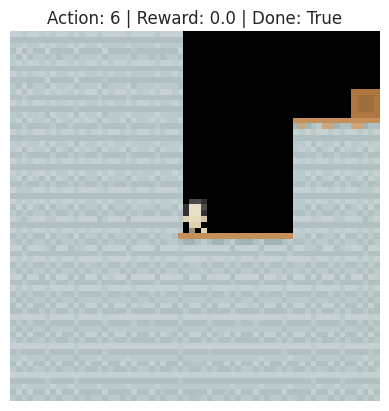

In [26]:
import IPython.display as display

agent = ProcgenProcessing.get_agent()
try:
    done = False
    while not done:
        ts = vec_object_env.current_time_step()
        policy_step = agent.policy.action(ts)
        ts = vec_object_env.step(policy_step.action)
        
        obs = ts.observation[0]
        reward = ts.reward[0]
        done = ts.is_last()[0]

        plt.imshow(obs)
        plt.axis('off')
        plt.title(f'Action: {action} | Reward: {reward} | Done: {done}')
        plt.show()
        display.clear_output(wait=True)
except KeyboardInterrupt:
    pass